In [112]:
## Bibliotheques

import numpy as np
import pandas as pd
import os
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Rajouté

import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Chargement des données

In [113]:
##  Chargement des donnees

def root_directory():  ## Chemin global d'acces, à changer selon l'utilisateur, ne pas oublier d'inclure "data"
    in_file = os.path.abspath("C:/Users/Maxence/Documents/Nico_Temporaire/Projet Fil rouge/code/heart.csv")
    return pd.read_csv(in_file)

In [114]:
## On récupère les données d'entrainement dans un DataFrame pandas
data = root_directory()
data.head()  ## On affiche le début du DataFrame afin de vérifier le bon chargement

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [115]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

On n'a aucune valeur manquante donc aucune action à faire sur le dataset

In [116]:
target = 'HeartDisease'  ## Ici la target est la feature 'condition'
hrv_features = list(data)  ## On fait une liste à partir de la DataFrame d'entrainement 
hrv_features = [x for x in hrv_features if x not in [target]]  ## On y élimine la target
X = data[hrv_features]
y = data.HeartDisease

On vérifie maintenant le type des valeurs de chaques features pour faires les transformations nécessaires

In [117]:
for feature in hrv_features:
  print("Feature:",feature)
  print(data[feature].describe())

Feature: Age
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64
Feature: Sex
count     918
unique      2
top         M
freq      725
Name: Sex, dtype: object
Feature: ChestPainType
count     918
unique      4
top       ASY
freq      496
Name: ChestPainType, dtype: object
Feature: RestingBP
count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64
Feature: Cholesterol
count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64
Feature: FastingBS
count    918.000000
mean       0.233115
std        0.423046
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max     

On va donc devoir numériser les features Sex, ChestPaintype, RestingECG, ExercseAngina and ST_Slope

On identifie les valeurs pour ces objets

In [118]:
print('Sex: ', X['Sex'].unique())
print('ChestPainType: ' , X['ChestPainType'].unique())
print('RestingECG: ', X['RestingECG'].unique())
print('ExerciseAngina: ', X['ExerciseAngina'].unique())
print('ST_Slope: ', X['ST_Slope'].unique())

Sex:  ['M' 'F']
ChestPainType:  ['ATA' 'NAP' 'ASY' 'TA']
RestingECG:  ['Normal' 'ST' 'LVH']
ExerciseAngina:  ['N' 'Y']
ST_Slope:  ['Up' 'Flat' 'Down']


Numérisation avec la fonctin map

In [119]:
X['Sex'] = X['Sex'].map({'M':0,'F':1})
X['ChestPainType'] = X['ChestPainType'].map({'ATA':0,'NAP':1,'ASY':2,'TA':3})
X['RestingECG'] = X['RestingECG'].map({'Normal':0,'ST':1,'LVH':2})
X['ExerciseAngina'] = X['ExerciseAngina'].map({'N':0,'Y':1})
X['ST_Slope'] = X['ST_Slope'].map({'Up':0,'Flat':1,'Down':2})

On vérifie que toutes les données sont bien de type numérique

In [120]:
for feature in hrv_features:
  print("Feature:",feature)
  print(X[feature].describe())

Feature: Age
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64
Feature: Sex
count    918.000000
mean       0.210240
std        0.407701
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Sex, dtype: float64
Feature: ChestPainType
count    918.000000
mean       1.452070
std        0.851832
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: ChestPainType, dtype: float64
Feature: RestingBP
count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64
Feature: Cholesterol
count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      60

Séparation des features en fonction de la target

In [121]:
class_failure = 1
class_no_failure = 0

failure_risk = X[y == class_failure]
failure_no_risk = X[y == class_no_failure]

On utilise des histogramme pour voir l'influence de chaque features pour différencier chaque classe

[]

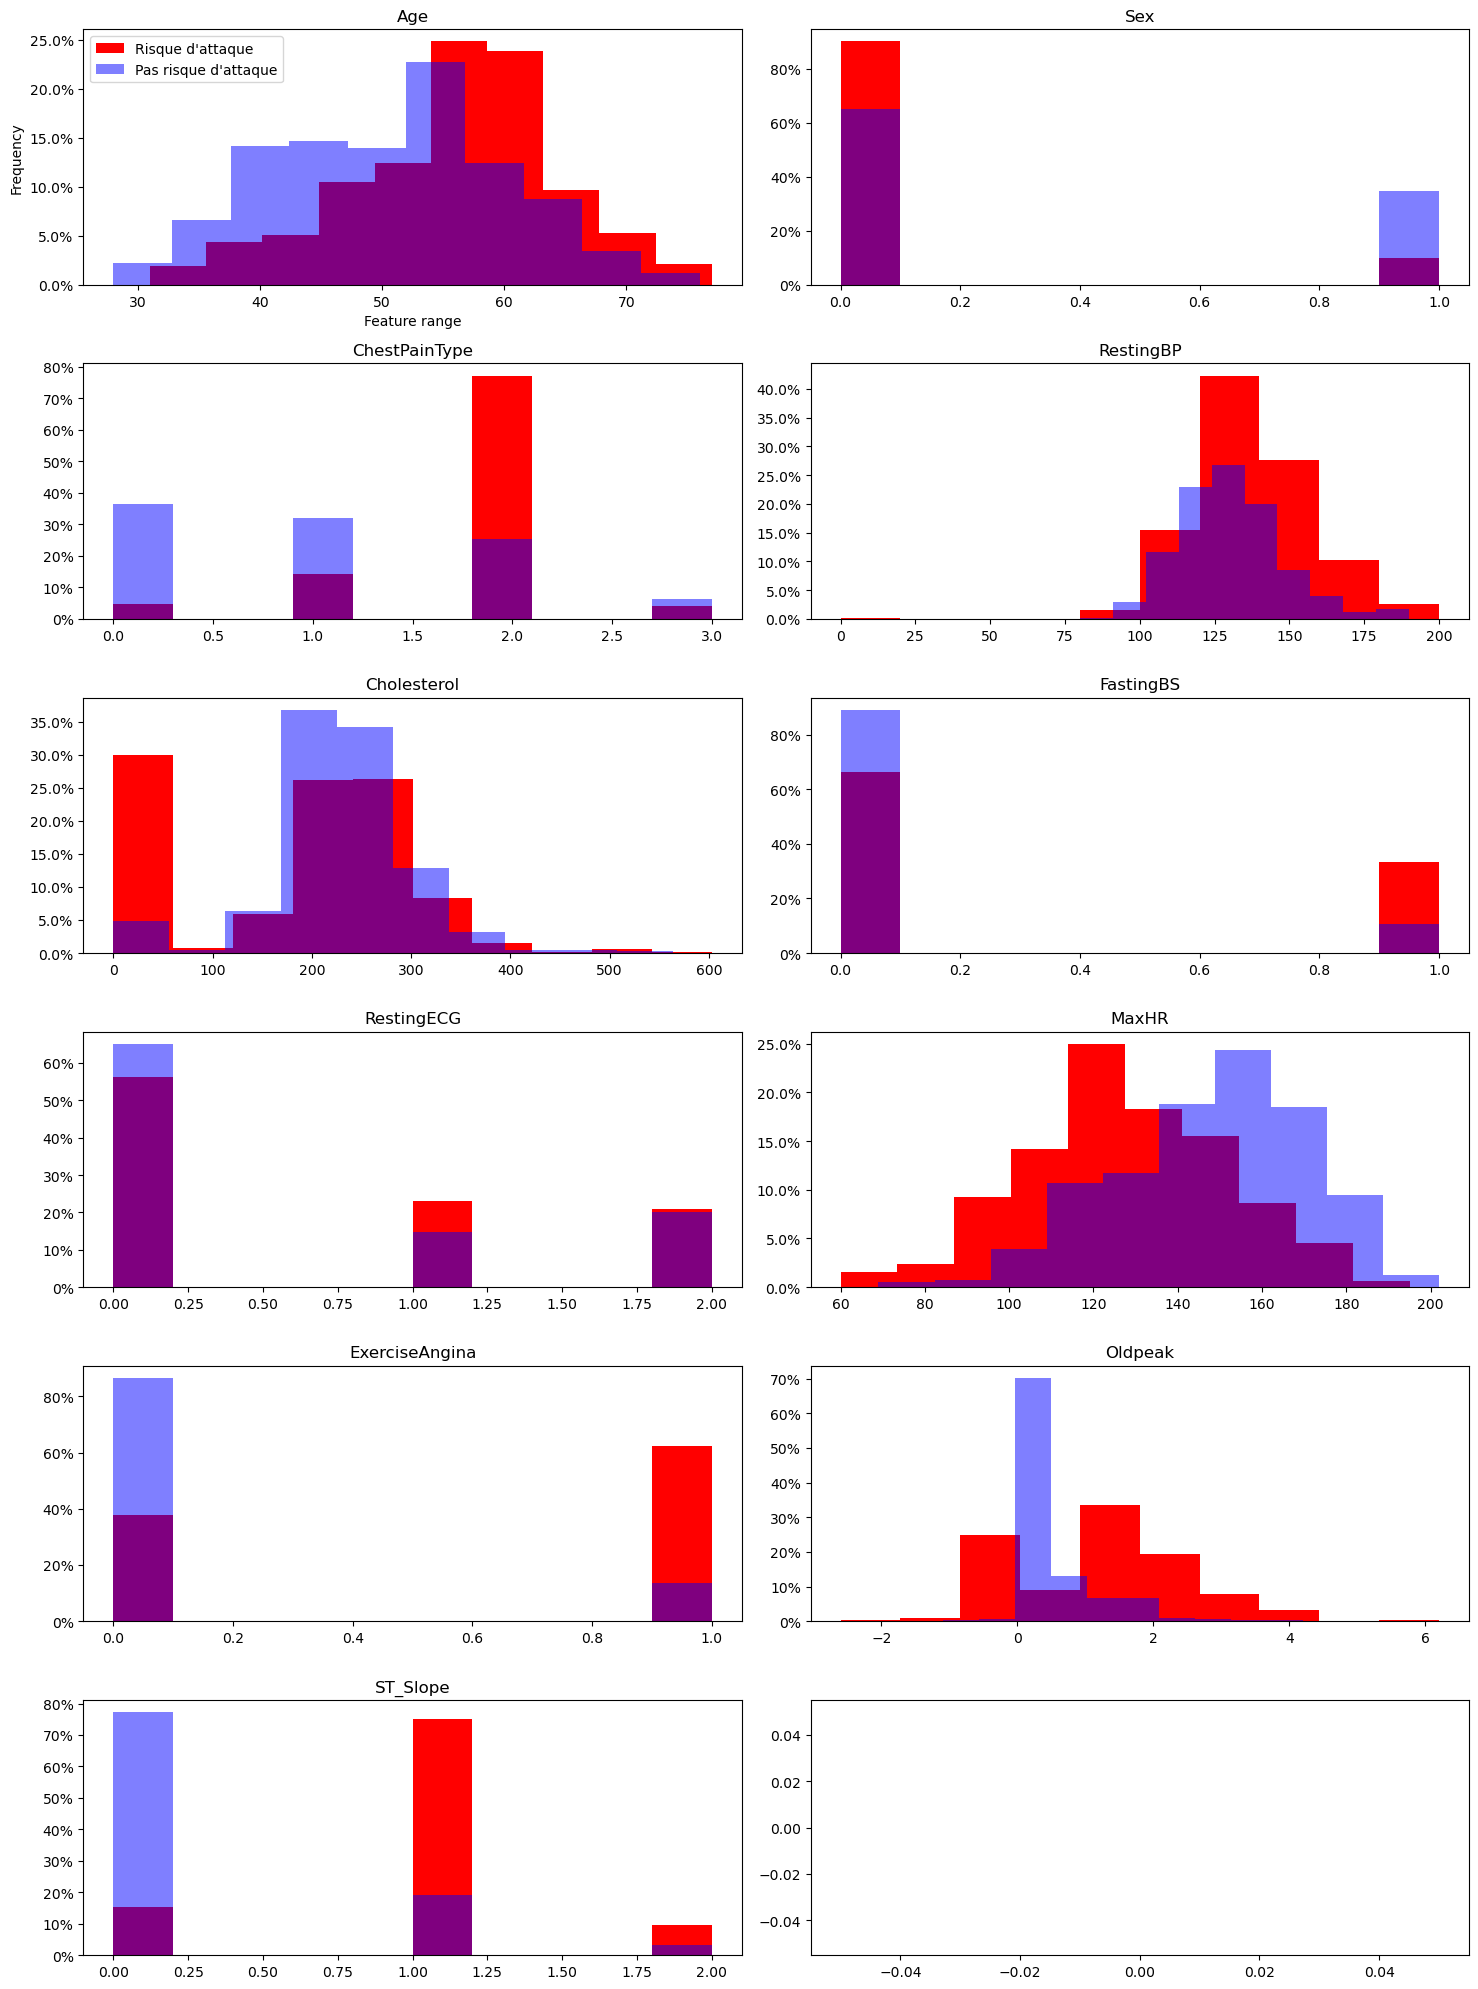

In [122]:
## Avec la suppression de "target" afin d'avoir nos données d'entrainements, le nombre d'éléments restant est impaire, nous rajoutons donc '+1' à la taille de 'hrv_features'
fig, axes = plt.subplots(int(len(X.columns) /2 +1), 2, figsize = (15,20)) ## Met en place les bases des graphes

axes = axes.ravel()
for i, feature in enumerate(X.columns): ## Pour chaque feature
  axes[i].set_title(feature) ## On nomme la figure par sa feature
  ## Le label alpha permet de voir la superposition des données, weights rend ici le graphe plus lisible
  axes[i].hist(failure_risk[feature], color='red', label="Risque d'attaque",  weights=np.ones(len(failure_risk)) / len(failure_risk)) 
  axes[i].hist(failure_no_risk[feature], color='blue', alpha=0.5, label="Pas risque d'attaque",  weights=np.ones(len(failure_no_risk)) / len(attack_no_risk)) 
  axes[i].yaxis.set_major_formatter(PercentFormatter(1)) ## On formatte les valeurs afin de rendre le graphe plus lisible
axes[0].set_xlabel("Feature range") ## Commentaire abscisses
axes[0].set_ylabel("Frequency") ## Commentaire ordonnée
axes[0].legend() ## Legendes
plt.tight_layout() ## Donne un padding adapté
plt.plot() ## On affiche les graphes

On peut remarquer l'influence des certaines features, on va confirmer ça avec un test d'indépendance et de corrélation

In [123]:
## Afin d'éviter des données trop proches, l'usage des données dans leur entiereté via ConcatX pour créer les 3 dataframes de target est nécessaire
liste = [] ## Liste recueillant les features dépendantes entre les 3 types de target 
for feature in X.columns: ## Pour chaque feature restante
    cpt = 0 ## Compteur déterminant si la feature est indépendante entre les 3 ou seulement entre 2
    t_test = ttest_ind(failure_no_risk[feature], failure_risk[feature]) ## Test d'indépendance entre no_stress et interruption
    if t_test.pvalue > 0.5: ## Si il y'a plus de 50% de dépendances, on affiche ses informations
        print("Pour Heart Failure et No Heart Failure")
        print("Pour la feature:", feature)
        print(" - t-statistic:", np.around(t_test.statistic, 3))
        print(" - p_value :", np.around(t_test.pvalue, 3))
        liste.append(feature)
print("3: ",liste)

3:  []


Aucune features ne sortent de ce test d'independance, on garde donc toutes les features

In [124]:
from scipy.stats import pearsonr

kept_columns = X.columns.to_list() ## On créé une liste à partir de nos features restantes

for i in range(len(kept_columns) - 1,-1,-1):
  print(kept_columns[i])
  for j in range(i - 1,-1,-1):
    corr, p_value = pearsonr(X[kept_columns[i]],X[kept_columns[j]]) ## Test de corrélation
    if abs(corr) >= 0.8 and p_value < 0.05: ## Si il y'a corrélation
      print(" - Correlation de",np.around(corr,3), "- p_value: ",np.around(p_value,3),"avec",kept_columns[j])
      del kept_columns[i] ## On supprime la feature de la liste
      break

print('-',kept_columns)

ST_Slope
Oldpeak
ExerciseAngina
MaxHR
RestingECG
FastingBS
Cholesterol
RestingBP
ChestPainType
Sex
Age
- ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


Les 11 features resortent de ce test de corrélations, notre dataset reste donc inchangé.

Toutes les features ont leur importance

## Mise en place d'un modèle

Nous avons des données labélisées, nous allons donc faire de l'apprentissage supervisé

In [125]:
## Bibliothèques

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import rand_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.datasets import make_classification, make_regression
from sklearn import metrics

#Pour regression logistique 
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score

Définition des deux labels

In [126]:
label_name = ['Heart Failure No Risk','Heart Failure Risk']

Définition de fonctions pour afficher les résultats de certains modèles

In [127]:
# Fonction pour faciliter la visualisation de la matrice de confusion
def plot_confusion_matrix(cm, class_labels=None, title='Confusion Matrix', cmap=plt.cm.Blues):

  plt.matshow(cm, cmap=cmap, alpha=0.3)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Vraies classes', fontsize=18)
  plt.title(title, fontsize=18)

# Fonction pour visualiser un estimator d'un random tree forest

def get_estimator_visualisation(estimator, kept_columns, label_name):
  # Export as dot file
  export_graphviz(estimator, out_file='tree.dot',
                  feature_names = kept_columns,
                  class_names = label_name,
                  rounded = True, proportion = False,
                  precision = 2, filled = True)

  # Convert to png using system command (requires Graphviz)
  call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

  # Display in jupyter notebook, not working in google collab
  Image(filename = 'tree.png')


def get_SVC_visualiser(X_2d):
  x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
  y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
  h = 0.02  # Mesh step size
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


#### Split des données entre celles d'entrainement et de test

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

On normalise les données pour réduire le temps d'éxecution de l'algorithme. cela influence aussi la performance des algorithme de classification par distance (non tree) comme SVC

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X)
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

### Tests des algorithmes des algorithmes de classifications sans arbres

#### Regression Logistique

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# On prépare les hyperparamètres
param_grid = {'penalty': ['l1', 'l2', 'none'], 'C': [0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1, 10]}

# On effectue la régression logistique
model_logistic = LogisticRegression(random_state=42, fit_intercept=True)
search = GridSearchCV(model_logistic, param_grid, scoring='accuracy', cv=5) 
search.fit(X_train_norm, y_train) # On fit

model_logistic = search.best_estimator_ # On récupère ici le meilleur estimateur obtenue après test
print(search.best_estimator_)
y_test_pred = model_logistic.predict(X_test_norm) # On prédit y_test d'après X_test en utilisant la régression logistique
metrics.f1_score(y_test, y_test_pred, average='macro') # Test métrique F1 score

LogisticRegression(C=0.3, random_state=42)


0.8341346153846152

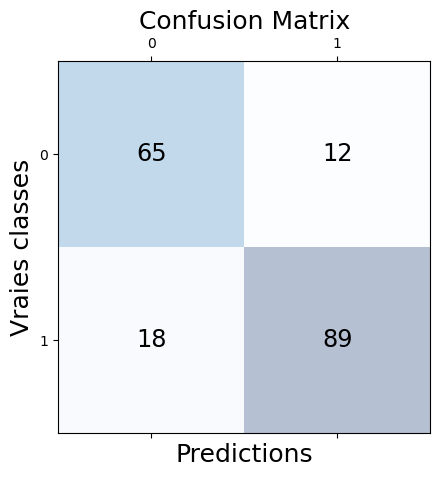

In [158]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

#### SVC

On teste les kernels rbf, linear et poly et linear renvoie les meilleurs résultats

SVC(C=1, gamma=0, kernel='linear', random_state=42)
0.8341346153846152
Rapport d'entrainement pour le random tree forest classifier
                       precision    recall  f1-score   support

Heart Failure No Risk       0.78      0.84      0.81        77
   Heart Failure Risk       0.88      0.83      0.86       107

             accuracy                           0.84       184
            macro avg       0.83      0.84      0.83       184
         weighted avg       0.84      0.84      0.84       184



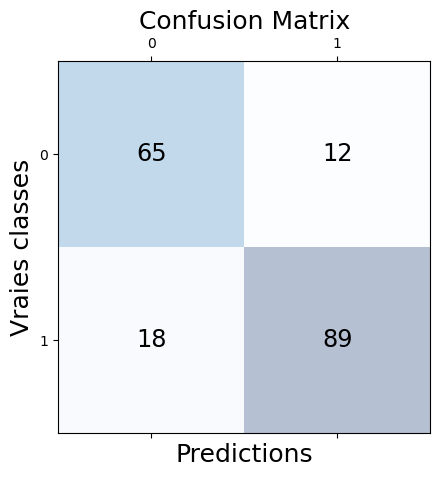

In [159]:

param_grid = {'gamma': [0, 0.01, 0.05, 0.1, 0.5, 1, 2], 'C': [0.1, 0.5, 1, 2, 5, 10, 25, 50]} 
model_SVC = SVC(kernel="linear", random_state=42)
search = GridSearchCV(model_SVC, param_grid, scoring='accuracy', cv=5) 
search.fit(X_train_norm, y_train) # On fit

model_SVC = search.best_estimator_ # On récupère ici le meilleur estimateur obtenue après test
print(search.best_estimator_)
y_test_pred = model_SVC.predict(X_test_norm) # On prédit y_test d'après X_test en utilisant le SVC

print(metrics.f1_score(y_test, y_test_pred, average='macro')) # Test métrique F1 score


accuracy = model_SVC.score(X_test_norm, y_test)

report = classification_report(y_test,y_test_pred,target_names = label_name)
print("Rapport d'entrainement pour le random tree forest classifier")
print(report)

plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

#### Cat Boost

pip install catboost

0:	learn: 0.3076754	total: 64.7ms	remaining: 32.3s
1:	learn: 0.1694533	total: 125ms	remaining: 31.1s
2:	learn: 0.1073191	total: 187ms	remaining: 30.9s
3:	learn: 0.0787162	total: 246ms	remaining: 30.5s
4:	learn: 0.0621063	total: 313ms	remaining: 31s
5:	learn: 0.0476473	total: 385ms	remaining: 31.7s
6:	learn: 0.0393448	total: 446ms	remaining: 31.4s
7:	learn: 0.0334123	total: 504ms	remaining: 31s
8:	learn: 0.0285005	total: 564ms	remaining: 30.8s
9:	learn: 0.0250264	total: 627ms	remaining: 30.7s
10:	learn: 0.0223790	total: 688ms	remaining: 30.6s
11:	learn: 0.0197940	total: 748ms	remaining: 30.4s
12:	learn: 0.0178497	total: 810ms	remaining: 30.4s
13:	learn: 0.0164253	total: 877ms	remaining: 30.4s
14:	learn: 0.0151698	total: 940ms	remaining: 30.4s
15:	learn: 0.0141349	total: 1s	remaining: 30.4s
16:	learn: 0.0130612	total: 1.07s	remaining: 30.3s
17:	learn: 0.0121697	total: 1.12s	remaining: 30.1s
18:	learn: 0.0113819	total: 1.18s	remaining: 29.9s
19:	learn: 0.0107289	total: 1.24s	remaining: 29

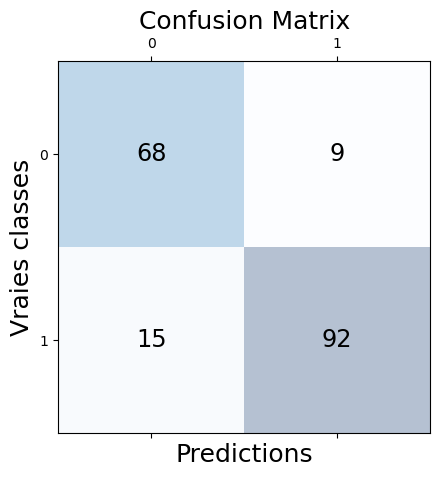

In [162]:
from catboost import CatBoostClassifier
model_catboost = CatBoostClassifier(iterations=500,
                          learning_rate=0.9,
                          depth=12)
# Fit model
model_catboost.fit(X_train_norm, y_train)
# Get predictions
y_pred = model_catboost.predict(X_test_norm)
#preds_proba = model.predict_proba(X_test_norm)
#preds_raw = model.predict(X_test_norm, prediction_type='RawFormulaVal')
print(metrics.f1_score(y_test, y_pred, average="macro")) # Test métrique F1 score
report = classification_report(y_test,y_test_pred,target_names = label_name)
print("Rapport d'entrainement pour le random tree forest classifier")
print(report)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Gradient Boost

GradientBoostingClassifier(learning_rate=0.7, n_estimators=70, random_state=42)
Rapport d'entrainement pour le random tree forest classifier
                       precision    recall  f1-score   support

Heart Failure No Risk       0.78      0.87      0.82        77
   Heart Failure Risk       0.90      0.82      0.86       107

             accuracy                           0.84       184
            macro avg       0.84      0.85      0.84       184
         weighted avg       0.85      0.84      0.84       184

0.8403112374682029


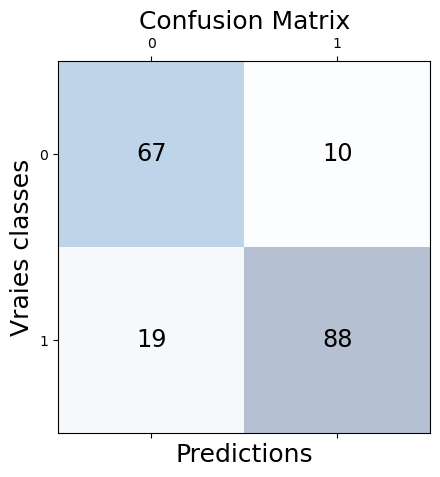

In [163]:
param_grid = {'n_estimators': [50, 60, 70, 80], 'learning_rate': [0.6, 0.7, 0.8,1]} 
model_gradientboost = GradientBoostingClassifier(random_state=42)
search = GridSearchCV(model_gradientboost, param_grid, scoring='accuracy', cv=5) 
search.fit(X_train_norm, y_train) # On fit

model_gradientboost = search.best_estimator_ # On récupère ici le meilleur estimateur obtenue après test
print(search.best_estimator_)
y_test_pred = model_gradientboost.predict(X_test_norm)

report = classification_report(y_test,y_test_pred,target_names = label_name)
print("Rapport d'entrainement pour le random tree forest classifier")
print(report)
print(metrics.f1_score(y_test, y_test_pred, average="macro")) # Test métrique F1 score
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred))

### Tests des algorithmes des algorithmes de classifications à base d'arbres

#### Decision Tree Classifier

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)
accuracy:  0.8586956521739131
0.8403112374682029
Rapport d'entrainement pour le decision tree classifier
                       precision    recall  f1-score   support

Heart Failure No Risk       0.83      0.83      0.83        77
   Heart Failure Risk       0.88      0.88      0.88       107

             accuracy                           0.86       184
            macro avg       0.85      0.85      0.85       184
         weighted avg       0.86      0.86      0.86       184



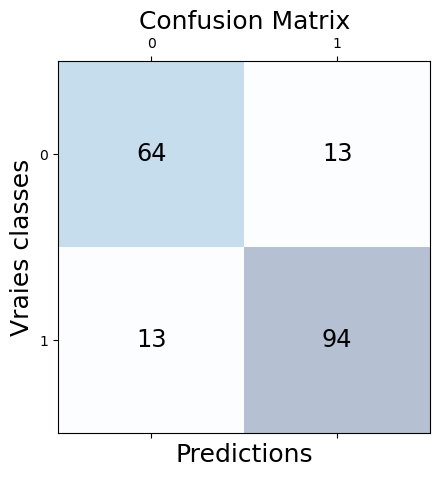

In [177]:
# On met en place les paramètres
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2,3, 4, 5, 6], 'min_samples_split': [2, 3, 5, 6, 10], 'min_samples_leaf': [5, 10, 15, 20]}

# On execute l'arbre de décision
model_decisiontree = DecisionTreeClassifier()
search = GridSearchCV(model_decisiontree, param_grid, scoring='f1_macro', cv=10)
# On fit
search.fit(X_train_norm, y_train)

model_decisiontree = search.best_estimator_ # On récupère ici le meilleur estimateur obtenue après test
print(search.best_estimator_)
y_pred = model_decisiontree.predict(X_test_norm) # On prédit y_test d'après X_test en utilisant l'arbre de décision

# Utiliser la fonction score du model pour calculer la précision
accuracy = model_decisiontree.score(X_test_norm, y_test)
print("accuracy: ", accuracy)
print(metrics.f1_score(y_test, y_test_pred, average="macro")) # Test métrique F1 score
# Génération d'un rapport de classification
report = classification_report(y_test,y_pred,target_names = label_name)
print("Rapport d'entrainement pour le decision tree classifier")
print(report)

# Création d'une matrice de confusion
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Random Tree Forest

accuracy : 0.8586956521739131
0.8403112374682029
Rapport d'entrainement pour le random tree forest classifier
                       precision    recall  f1-score   support

Heart Failure No Risk       0.81      0.87      0.84        77
   Heart Failure Risk       0.90      0.85      0.88       107

             accuracy                           0.86       184
            macro avg       0.85      0.86      0.86       184
         weighted avg       0.86      0.86      0.86       184



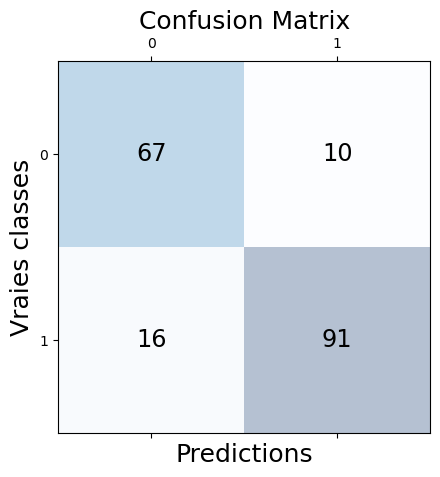

In [176]:
# Créer un classifer avec 10 estimateurs
modelrandomforest = RandomForestClassifier(n_estimators=10) #utilisation de 10 arbres nos données même divisées en 10 arbres restent suffisantes 
# Utiliser la propriété fit pour entrainer le classifier
modelrandomforest.fit(X_train_norm, y_train)

# Extraction d'un estimateur pour le visualiser
estimator = modelrandomforest.estimators_[3] #arbre numero 3
get_estimator_visualisation(estimator, kept_columns, label_name)

# Passer les données non présentes lors de l'entrainement pour vérifier la qualité de cet entrainement avec la fonction predict
y_pred = modelrandomforest.predict(X_test_norm)

# Utiliser la fonction score du model pour calculer la précision
accuracy = modelrandomforest.score(X_test_norm, y_test)
print("accuracy :", accuracy)
print(metrics.f1_score(y_test, y_test_pred, average="macro")) # Test métrique F1 score
# Génération d'un rapport de classification
report = classification_report(y_test,y_pred,target_names = label_name)
print("Rapport d'entrainement pour le random tree forest classifier")
print(report)

# Création d'une matrice de confusion
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

Le meilleur modèe obtenu est celui avec le decision tree classifier. En effet pour des données de santé le recall (basé sur les resultats postifs) est le plus important 

## Test sur des données réelles

### Récuperation de données

In [165]:
#Importation des modules
import serial
import serial.tools.list_ports   # pour la communication avec le port série
import numpy as np
#initialisation des listes
liste_distance = []

In [166]:
# Fonction pour la récupération des données série venant de la carte Arduino
def recup_port_Arduino() :
    ports = list(serial.tools.list_ports.comports())
    for p in ports:
        print(p.description)
        if 'USB-SERIAL' in p.description :
            mData = serial.Serial(p.device,9600)
    print(mData.is_open) # Affiche et vérifie que le port est ouvert
    print(mData.name) # Affiche le nom du port 
    return mData

In [167]:
#On remet la variable Data à 0 pour éviter un bug 
Data = {}
Data = recup_port_Arduino()

Lien série sur Bluetooth standard (COM3)
Lien série sur Bluetooth standard (COM4)
USB-SERIAL CH340 (COM5)
True
COM5


On récupère la première ligne (qui ne nous intéresse pas) et on teste la fonction split

In [169]:
line1 = Data.readline() 
print (line1)
donnee=line1.strip().split()
print (donnee)

b'BPM: 87\r\n'
[b'BPM:', b'87']


In [170]:
# Essai pour une succession de 20 lignes de données
liste_distance = []
for k in range(20) :
    line1 = Data.readline() 
    print (line1)
    donnee=line1.strip().split()
    print (donnee)

    if len(donnee) !=0 : # parfois des lignes de données vides peuvent être envoyées, il faut les "écarter"
        distance = float(donnee[1].decode())  # après consultation des données, nous choisissons le 5ème élément de listeDonnees
        liste_distance.append(distance)
        print ("BPM : ", distance, " batts/min")

Data.close()   # pour arrêter la lecture des données série

b'BPM: 101\r\n'
[b'BPM:', b'101']
BPM :  101.0  batts/min
b'BPM: 110\r\n'
[b'BPM:', b'110']
BPM :  110.0  batts/min
b'BPM: 109\r\n'
[b'BPM:', b'109']
BPM :  109.0  batts/min
b'BPM: 100\r\n'
[b'BPM:', b'100']
BPM :  100.0  batts/min
b'BPM: 107\r\n'
[b'BPM:', b'107']
BPM :  107.0  batts/min
b'BPM: 106\r\n'
[b'BPM:', b'106']
BPM :  106.0  batts/min
b'BPM: 116\r\n'
[b'BPM:', b'116']
BPM :  116.0  batts/min
b'BPM: 131\r\n'
[b'BPM:', b'131']
BPM :  131.0  batts/min
b'BPM: 129\r\n'
[b'BPM:', b'129']
BPM :  129.0  batts/min
b'BPM: 114\r\n'
[b'BPM:', b'114']
BPM :  114.0  batts/min
b'BPM: 108\r\n'
[b'BPM:', b'108']
BPM :  108.0  batts/min
b'BPM: 108\r\n'
[b'BPM:', b'108']
BPM :  108.0  batts/min
b'BPM: 114\r\n'
[b'BPM:', b'114']
BPM :  114.0  batts/min
b'BPM: 113\r\n'
[b'BPM:', b'113']
BPM :  113.0  batts/min
b'BPM: 114\r\n'
[b'BPM:', b'114']
BPM :  114.0  batts/min
b'BPM: 111\r\n'
[b'BPM:', b'111']
BPM :  111.0  batts/min
b'BPM: 103\r\n'
[b'BPM:', b'103']
BPM :  103.0  batts/min
b'BPM: 108\r\n

In [172]:
print(liste_distance)
liste_distance_filtered = []
for i in range(len(liste_distance)):
    if (liste_distance[i]<200 and liste_distance[i] > 60) :
        liste_distance_filtered.append(liste_distance[i])
valfinale = np.max(liste_distance_filtered)
print(liste_distance_filtered)
print(valfinale)

[101.0, 110.0, 109.0, 100.0, 107.0, 106.0, 116.0, 131.0, 129.0, 114.0, 108.0, 108.0, 114.0, 113.0, 114.0, 111.0, 103.0, 108.0, 114.0, 107.0]
[101.0, 110.0, 109.0, 100.0, 107.0, 106.0, 116.0, 131.0, 129.0, 114.0, 108.0, 108.0, 114.0, 113.0, 114.0, 111.0, 103.0, 108.0, 114.0, 107.0]
131.0


### Création des personnes

Maintenant que nous avons la valeur du BPM, on créé un fichier txt avec les valeurs que l'on veut

Création d'un personnage

In [217]:
def attribus(valfinale):
    Age = int(input("Votre age ?"))
    Sex = int(input("Votre sexe (0 masculin, 1 feminin)?"))
    chestPainType = int(input("Avez vous eu des douleurs à la poitrine (0 Atypical Angine, 1 Non Anginal Pain, 2 Asymptomatique, 3 Typical Angina)?"))
    RestingBP = int(input("Quelle est votre pression sanguine au repos(mm Hg) ?"))
    Cholesterol = int(input("Quelle est votre cholesterol(mm/dl) ?"))
    FastingBS = int(input("Votre glycémie ajeun ? (1 si >120 mg/dl 0 sinon)?"))
    RestingECG = int(input("Vos resultats d'ECG (0 Normal, 1 anormalité de l'onde ST-T, 2 Ventricular hypertrophy )?"))
    MaxHR = valfinale
    ExerciseAngina = int(input("Avez vous eu une angine provoquée par de l'exercice (0 Non, 1 Oui)?"))
    OldPeak = int(input("Combien de millimetres fait la dépression de l'onde ST (0 (RAS), sinon renseigner valeur)?")) # En bonne santé
    ST_Slope = int(input("la pente du segment ST de l’exercice de pointe (0 Haut(Bon), 1 Plat(Mauvais), 2 Descend(Plutot mauvais))?"))
    return Age, Sex, chestPainType, RestingBP, Cholesterol, FastingBS, RestingECG,MaxHR, ExerciseAngina, OldPeak, ST_Slope


Sex:  ['M' 'F']
ChestPainType:  ['ATA' 'NAP' 'ASY' 'TA']
RestingECG:  ['Normal' 'ST' 'LVH']
ExerciseAngina:  ['N' 'Y']
ST_Slope:  ['Up' 'Flat' 'Down']

In [219]:
attribus_personnage = attribus(valfinale)

21, 0, 1, 120, 180, 0, 0, 131.0, 0, 0.9050408719346048, 0

### Predictions

In [220]:
attribus_array = np.array(attribus_personnage)
X_final = pd.DataFrame(data=[attribus_array], columns= hrv_features)

In [221]:
X_final

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,21.0,0.0,1.0,120.0,180.0,0.0,0.0,131.0,0.0,0.0,0.0


In [228]:
y_final = model_catboost.predict(X_final)
print(y_final)

[0]


#### Individu malade

Michel, 50 ans, a des douleurs thoracique lorsqu'il monte les marches menant à son appprtement, a une pression sanguine au repos de 130 mmHg, a un taux de cholesterol normal de 180 mg/dl (normal), a une glycémie à jeun nférieur à 120mg/dl(normal). Sur son ECG, on peut remarquer une dépression de l'onde ST (voire image) d'une valeur de 1 millimètre. On remarque aussi un downsloping sur l'onde ST (voir image)

In [231]:
attribus_personnage = attribus(160)

In [232]:
attribus_malade = np.array(attribus_personnage)
X_malade = pd.DataFrame(data=[attribus_malade], columns= hrv_features)

In [233]:
X_malade

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,50,0,3,130,180,0,1,160,1,0,2


In [234]:
y_malade = model_catboost.predict(X_malade)
print(y_malade)

[1]
